In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
#import elo

In [4]:
#%more update_stash.py

In [5]:
%run update_stash.py

unzipping  ../../Football_Data/Zipstash\data_0.zip
unzipping  ../../Football_Data/Zipstash\data_1.zip
unzipping  ../../Football_Data/Zipstash\data_10.zip
unzipping  ../../Football_Data/Zipstash\data_11.zip
unzipping  ../../Football_Data/Zipstash\data_12.zip
unzipping  ../../Football_Data/Zipstash\data_13.zip
unzipping  ../../Football_Data/Zipstash\data_14.zip
unzipping  ../../Football_Data/Zipstash\data_15.zip
unzipping  ../../Football_Data/Zipstash\data_16.zip
unzipping  ../../Football_Data/Zipstash\data_17.zip
unzipping  ../../Football_Data/Zipstash\data_18.zip
unzipping  ../../Football_Data/Zipstash\data_19.zip
unzipping  ../../Football_Data/Zipstash\data_2.zip
unzipping  ../../Football_Data/Zipstash\data_20.zip
unzipping  ../../Football_Data/Zipstash\data_21.zip
unzipping  ../../Football_Data/Zipstash\data_22.zip
unzipping  ../../Football_Data/Zipstash\data_23.zip
unzipping  ../../Football_Data/Zipstash\data_24.zip
unzipping  ../../Football_Data/Zipstash\data_25.zip
unzipping  ../.

In [6]:
all_seasons = []
for filename in os.listdir('C:/Users/bfesc/Documents/Football_Data/Stash/'):
    #if filename[0] == 'B':
    with open("C:/Users/bfesc/Documents/Football_Data/Stash/" + filename) as file:
        season = file.read().rstrip().split('\n')
        for i in range(len(season)):
            season[i] = season[i].rstrip(',').split(',')
        all_seasons.append(season)

In [7]:
columns = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'WHH', 'WHD', 'WHA']

all_data = pd.DataFrame(columns=columns)
for season in all_seasons:
    if not np.in1d(columns, season[0]).all():
        continue
    if len(season[0]) != max([len(s) for s in season]):
        for i in range(len(season)):
            season[i] = season[i][:len(season[0])]
    df = pd.DataFrame(season[1:])
    df.columns = season[0]
    all_data = all_data.append(df[columns])
    
all_data['Date'] = pd.to_datetime(all_data['Date'], dayfirst=True)
all_data.index = all_data['Date']
all_data = all_data.drop(columns=['Date','Div'])
for column in all_data.columns:
    all_data = all_data[pd.notnull(all_data[column])]
all_data = all_data[pd.notnull(all_data.index)]
all_data = all_data.iloc[np.where(all_data['WHH'] != "")]
all_data = all_data.iloc[np.where(all_data['WHD'] != "")]
all_data = all_data.iloc[np.where(all_data['WHA'] != "")]
all_data = all_data.iloc[np.where(all_data['FTHG'] != "")]
all_data = all_data.sort_index(ascending=False)
all_data['FTR'].iloc[np.where(all_data['FTR'] == 'A')] = -1
all_data['FTR'].iloc[np.where(all_data['FTR'] == 'D')] = 0
all_data['FTR'].iloc[np.where(all_data['FTR'] == 'H')] = 1
all_data['FTHG'] = all_data['FTHG'].astype(int)
all_data['FTAG'] = all_data['FTAG'].astype(int)
all_data['WHH'] = all_data['WHH'].astype(np.float32)
all_data['WHD'] = all_data['WHD'].astype(np.float32)
all_data['WHA'] = all_data['WHA'].astype(np.float32)

In [8]:
all_data.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,WHH,WHD,WHA
Date,,,,,,,,
2021-04-08,Stenhousemuir,Cowdenbeath,1,0,1,1.80,3.5,4.0
2021-04-08,Denizlispor,Kasimpasa,1,1,0,2.90,3.2,2.4
2021-04-08,Dumbarton,East Fife,2,1,1,3.60,3.2,2.0
2021-04-08,Clyde,Forfar,3,0,1,1.80,3.6,3.9
2021-04-08,Hannover,Wurzburger Kickers,1,2,-1,1.57,3.9,5.5


In [9]:
#elo.rate_1vs1(1200,1100)

In [10]:
def make_team_dicts(data):
    all_teams = np.unique(np.append(data['HomeTeam'], data['AwayTeam']))
    team_dict = {}
    
    for team in all_teams:
        team_dict[team] = data.iloc[np.where(np.logical_or(data['HomeTeam'] == team, 
                                                      data['AwayTeam'] == team))].sort_index(ascending=False)
        
    return team_dict

In [16]:
def make_training_set(all_data, n_matches=None):


    #training_data = pd.DataFrame(columns=['DaysSinceLastHTMatch', 'DaysSinceLastATMatch', 'HomeTeamForm', 'AwayTeamForm',
    #                                        'HomeTeamHomeForm','AwayTeamAwayForm', 'HomeTeamOffense', 'HomeTeamDefense',
    #                                      'AwayTeamOffense', 'AwayTeamDefense', 'LastInterTeamGame', 'Result', 'HomeValue',
    #                                     'AwayValue'])
    training_data = []
    kolonner = ['DaysSinceLastHTMatch', 'DaysSinceLastATMatch', 'HomeTeamForm', 'AwayTeamForm',
                'HomeTeamHomeForm','AwayTeamAwayForm', 'HomeTeamOffense', 'HomeTeamDefense',
                'AwayTeamOffense', 'AwayTeamDefense', 'LastInterTeamGame', 'Result', 'HomeValue',
                'AwayValue']
    
    if n_matches is None:
        n_matches = len(all_data.index)

    history = pd.Timedelta('90d')
    year = pd.Timedelta('365d')

    for i in tqdm(range(n_matches)):#
        game = all_data.iloc[i]

        home_team = game['HomeTeam']
        away_team = game['AwayTeam']
        game_date = game.name 

        ht_games = team_dict[home_team].loc[game_date - pd.Timedelta('1h'):game_date - year]
        at_games = team_dict[away_team].loc[game_date - pd.Timedelta('1h'):game_date - year]

    #     ht_games['FTHG'] = ht_games['FTHG'].values / ht_time_diff
    #     ht_ag = ht_games['FTAG'].values / ht_time_diff

    #     at_hg = at_games['FTHG'].values / at_time_diff
    #     at_ag = at_games['FTAG'].values /at_time_diff

        #result = game['FTR']
        result = game['FTHG'] - game['FTAG']
        
        awayValue = -1
        homeValue = -1
        if result > 0:
            homeValue += float(game['WHH'])
        elif result < 0:
            awayValue += float(game['WHA'])
            
        ht_hgames = ht_games.iloc[np.where(ht_games['HomeTeam'] == home_team)]
        ht_agames = ht_games.iloc[np.where(ht_games['AwayTeam'] == home_team)]

        at_hgames = at_games.iloc[np.where(at_games['HomeTeam'] == away_team)]
        at_agames = at_games.iloc[np.where(at_games['AwayTeam'] == away_team)]


        if len(ht_hgames) > 1 and len(at_agames) > 1:

            ht_time_diff = np.log((game_date - ht_games.index).days.values + 1)
            at_time_diff = np.log((game_date - at_games.index).days.values + 1)

            ht_h_td = ht_time_diff[np.where(ht_games['HomeTeam'] == home_team)]
            ht_a_td = ht_time_diff[np.where(ht_games['AwayTeam'] == home_team)]
            at_h_td = at_time_diff[np.where(at_games['HomeTeam'] == away_team)]
            at_a_td = at_time_diff[np.where(at_games['AwayTeam'] == away_team)]


            it_games = np.append(np.where(ht_hgames['AwayTeam'] == away_team)[0],
                                 np.where(ht_agames['HomeTeam'] == away_team)[0])

            litgr = 0
            
            if len(it_games) > 0:
                litgr += np.mean((ht_games['FTHG'].iloc[it_games].values - ht_games['FTAG'].iloc[it_games].values) / ht_time_diff[it_games])

            dslhtm = ht_time_diff[0]
            dslatm = at_time_diff[0]

            ht_form = np.mean(np.append(((ht_hgames['FTHG'].values - ht_hgames['FTAG'].values) / ht_h_td),
                              (ht_agames['FTAG'].values - ht_agames['FTHG'].values) / ht_a_td))
            at_form = np.mean(np.append((at_hgames['FTHG'].values - at_hgames['FTAG'].values) / at_h_td,
                              (at_agames['FTAG'].values - at_agames['FTHG'].values) / at_a_td))

            ht_hform = np.mean((ht_hgames['FTHG'].values - ht_hgames['FTAG'].values) / ht_h_td)
            at_aform = np.mean((at_agames['FTAG'].values - at_agames['FTHG'].values) / at_a_td)

            hto = np.mean(np.append(ht_hgames['FTHG'].values / ht_h_td, ht_agames['FTAG'].values / ht_a_td))
            htd = -np.mean(np.append(ht_hgames['FTAG'].values / ht_h_td, ht_agames['FTHG'].values /ht_a_td))

            ato = np.mean(np.append(at_hgames['FTHG'] / at_h_td, at_agames['FTAG'].values / at_a_td))
            atd = -np.mean(np.append(at_hgames['FTAG'].values / at_h_td, at_agames['FTHG'].values / at_a_td))


#            training_data = training_data.append(pd.DataFrame([[dslhtm, dslatm, ht_form, at_form, ht_hform, at_aform,
#                                                                hto, htd, ato, atd, litgr, result, homeValue, awayValue]],
#                                                              columns=training_data.columns))
            training_data.append(dict(zip(kolonner, [dslhtm, dslatm, ht_form, at_form, ht_hform, at_aform,
                                            hto, htd, ato, atd, litgr, result, homeValue, awayValue])))
            

    return pd.DataFrame(training_data)
    
    

In [15]:
team_dict = make_team_dicts(all_data)

In [17]:
training_data = make_training_set(all_data)


  1%|▍                                                                           | 793/151062 [00:08<23:30, 106.52it/s]


  1%|▊                                                                           | 1562/151062 [00:16<25:53, 96.21it/s]


  2%|█▏                                                                          | 2336/151062 [00:23<26:19, 94.15it/s]


  2%|█▌                                                                         | 3208/151062 [00:30<20:33, 119.87it/s]


  3%|██                                                                          | 4033/151062 [00:38<26:07, 93.78it/s]


  3%|██▍                                                                        | 4800/151062 [00:45<22:49, 106.77it/s]


  4%|██▊                                                                        | 5644/151062 [00:53<23:57, 101.16it/s]


  4%|███▏                                                                       | 6433/151062 [01:01<22:49, 105.58it/s]


  5%|███▌                                                                       | 7287/151062 [01:08<18:29, 129.60it/s]


  5%|████                                                                       | 8150/151062 [01:15<18:38, 127.79it/s]


  6%|████▍                                                                      | 9040/151062 [01:22<19:16, 122.77it/s]


  7%|████▉                                                                      | 9897/151062 [01:29<18:55, 124.34it/s]


  7%|█████▎                                                                    | 10731/151062 [01:36<19:57, 117.17it/s]


  8%|█████▋                                                                    | 11574/151062 [01:43<19:16, 120.64it/s]


  8%|██████                                                                    | 12492/151062 [01:50<18:29, 124.94it/s]


  9%|██████▌                                                                   | 13378/151062 [01:57<19:31, 117.56it/s]


  9%|██████▉                                                                   | 14241/151062 [02:04<18:41, 121.98it/s]


 10%|███████▍                                                                  | 15117/151062 [02:11<18:13, 124.27it/s]


 11%|███████▊                                                                  | 15977/151062 [02:19<19:25, 115.86it/s]


 11%|████████▎                                                                 | 16857/151062 [02:26<17:57, 124.55it/s]


 12%|████████▋                                                                 | 17740/151062 [02:33<17:08, 129.61it/s]


 12%|█████████                                                                 | 18622/151062 [02:40<17:38, 125.11it/s]


 13%|█████████▌                                                                | 19513/151062 [02:47<16:59, 129.04it/s]


 14%|██████████                                                                | 20427/151062 [02:54<16:17, 133.60it/s]


 14%|██████████▍                                                               | 21294/151062 [03:01<17:43, 121.97it/s]


 15%|██████████▊                                                               | 22154/151062 [03:08<17:39, 121.69it/s]


 15%|███████████▎                                                              | 23030/151062 [03:15<17:44, 120.22it/s]


 16%|███████████▋                                                              | 23901/151062 [03:22<17:59, 117.84it/s]


 16%|████████████▏                                                             | 24784/151062 [03:29<16:32, 127.26it/s]


 17%|████████████▌                                                             | 25666/151062 [03:36<16:54, 123.60it/s]


 18%|█████████████                                                             | 26562/151062 [03:43<16:25, 126.36it/s]


 18%|█████████████▍                                                            | 27470/151062 [03:50<15:50, 130.09it/s]


 19%|█████████████▉                                                            | 28397/151062 [03:57<15:26, 132.36it/s]


 19%|██████████████▎                                                           | 29282/151062 [04:04<16:42, 121.51it/s]


 20%|██████████████▊                                                           | 30149/151062 [04:11<16:57, 118.79it/s]


 21%|███████████████▏                                                          | 31013/151062 [04:18<17:39, 113.36it/s]


 21%|███████████████▌                                                          | 31879/151062 [04:25<16:12, 122.54it/s]


 22%|████████████████                                                          | 32765/151062 [04:32<15:55, 123.79it/s]


 22%|████████████████▍                                                         | 33643/151062 [04:39<15:52, 123.23it/s]


 23%|████████████████▉                                                         | 34528/151062 [04:46<15:18, 126.83it/s]


 23%|█████████████████▎                                                        | 35435/151062 [04:53<14:31, 132.71it/s]


 24%|█████████████████▊                                                        | 36353/151062 [05:01<16:10, 118.24it/s]


 25%|██████████████████▏                                                       | 37216/151062 [05:08<15:23, 123.28it/s]


 25%|██████████████████▋                                                       | 38088/151062 [05:15<15:35, 120.76it/s]


 26%|███████████████████                                                       | 38959/151062 [05:22<14:21, 130.10it/s]


 26%|███████████████████▌                                                      | 39832/151062 [05:29<15:06, 122.65it/s]


 27%|███████████████████▉                                                      | 40721/151062 [05:36<14:01, 131.07it/s]


 28%|████████████████████▍                                                     | 41611/151062 [05:43<14:34, 125.22it/s]


 28%|████████████████████▊                                                     | 42502/151062 [05:50<14:18, 126.45it/s]


 29%|█████████████████████▎                                                    | 43424/151062 [05:57<13:36, 131.76it/s]


 29%|█████████████████████▋                                                    | 44321/151062 [06:04<14:54, 119.27it/s]


 30%|██████████████████████▏                                                   | 45186/151062 [06:11<14:42, 119.91it/s]


 30%|██████████████████████▌                                                   | 46034/151062 [06:18<16:29, 106.09it/s]


 31%|██████████████████████▉                                                   | 46898/151062 [06:25<14:25, 120.36it/s]


 32%|███████████████████████▍                                                  | 47777/151062 [06:32<13:57, 123.32it/s]


 32%|████████████████████████▏                                                  | 48640/151062 [06:39<17:09, 99.45it/s]


 33%|████████████████████████▎                                                 | 49515/151062 [06:46<14:03, 120.35it/s]


 33%|████████████████████████▋                                                 | 50398/151062 [06:53<13:39, 122.91it/s]


 34%|█████████████████████████▏                                                | 51310/151062 [07:00<13:05, 126.92it/s]


 35%|█████████████████████████▌                                                | 52211/151062 [07:07<13:23, 123.02it/s]


 35%|██████████████████████████                                                | 53084/151062 [07:15<13:13, 123.49it/s]


 36%|██████████████████████████▍                                               | 53944/151062 [07:22<13:26, 120.44it/s]


 36%|██████████████████████████▊                                               | 54815/151062 [07:29<13:21, 120.06it/s]


 37%|███████████████████████████▎                                              | 55691/151062 [07:36<12:04, 131.65it/s]


 37%|███████████████████████████▋                                              | 56578/151062 [07:43<12:39, 124.40it/s]


 38%|████████████████████████████▏                                             | 57459/151062 [07:50<12:26, 125.36it/s]


 39%|████████████████████████████▌                                             | 58352/151062 [07:57<12:02, 128.28it/s]


 39%|█████████████████████████████                                             | 59263/151062 [08:04<11:51, 128.98it/s]


 40%|█████████████████████████████▍                                            | 60122/151062 [08:11<12:05, 125.43it/s]


 40%|█████████████████████████████▊                                            | 60984/151062 [08:18<14:00, 107.12it/s]


 41%|██████████████████████████████▎                                           | 61857/151062 [08:25<12:09, 122.34it/s]


 42%|██████████████████████████████▋                                           | 62729/151062 [08:32<12:10, 120.98it/s]


 42%|███████████████████████████████▏                                          | 63603/151062 [08:39<11:31, 126.55it/s]


 43%|███████████████████████████████▌                                          | 64486/151062 [08:46<11:30, 125.36it/s]


 43%|████████████████████████████████                                          | 65383/151062 [08:53<11:19, 126.06it/s]


 44%|████████████████████████████████▍                                         | 66277/151062 [09:00<11:02, 127.96it/s]


 44%|████████████████████████████████▉                                         | 67197/151062 [09:07<10:44, 130.07it/s]


 45%|█████████████████████████████████▎                                        | 68076/151062 [09:14<11:21, 121.74it/s]


 46%|█████████████████████████████████▊                                        | 68911/151062 [09:21<10:55, 125.38it/s]


 46%|██████████████████████████████████▏                                       | 69788/151062 [09:28<11:15, 120.34it/s]


 47%|██████████████████████████████████▌                                       | 70654/151062 [09:36<10:52, 123.14it/s]


 47%|███████████████████████████████████                                       | 71537/151062 [09:43<10:40, 124.08it/s]


 48%|███████████████████████████████████▍                                      | 72432/151062 [09:50<10:19, 126.86it/s]


 49%|███████████████████████████████████▉                                      | 73330/151062 [09:57<10:50, 119.54it/s]


 49%|████████████████████████████████████▎                                     | 74236/151062 [10:04<09:58, 128.29it/s]


 50%|████████████████████████████████████▊                                     | 75149/151062 [10:11<10:27, 120.93it/s]


 50%|█████████████████████████████████████▏                                    | 76009/151062 [10:18<10:19, 121.16it/s]


 51%|█████████████████████████████████████▋                                    | 76887/151062 [10:25<09:30, 130.01it/s]


 51%|██████████████████████████████████████                                    | 77761/151062 [10:32<10:32, 115.95it/s]


 52%|██████████████████████████████████████▌                                   | 78638/151062 [10:39<09:30, 126.91it/s]


 53%|██████████████████████████████████████▉                                   | 79519/151062 [10:46<09:49, 121.28it/s]


 53%|███████████████████████████████████████▍                                  | 80402/151062 [10:53<09:38, 122.16it/s]


 54%|███████████████████████████████████████▊                                  | 81295/151062 [11:00<09:16, 125.29it/s]


 54%|████████████████████████████████████████▎                                 | 82194/151062 [11:07<09:11, 124.80it/s]


 55%|████████████████████████████████████████▋                                 | 83105/151062 [11:14<09:22, 120.78it/s]


 56%|█████████████████████████████████████████▏                                | 83975/151062 [11:21<09:06, 122.70it/s]


 56%|█████████████████████████████████████████▌                                | 84852/151062 [11:28<08:55, 123.59it/s]


 57%|█████████████████████████████████████████▉                                | 85712/151062 [11:35<08:44, 124.62it/s]


 57%|██████████████████████████████████████████▍                               | 86568/151062 [11:42<08:26, 127.22it/s]


 58%|██████████████████████████████████████████▊                               | 87455/151062 [11:50<08:28, 125.03it/s]


 58%|███████████████████████████████████████████▎                              | 88332/151062 [11:56<08:24, 124.41it/s]


 59%|███████████████████████████████████████████▋                              | 89211/151062 [12:04<08:02, 128.32it/s]


 60%|████████████████████████████████████████████▏                             | 90121/151062 [12:11<07:46, 130.64it/s]


 60%|████████████████████████████████████████████▌                             | 90995/151062 [12:18<08:17, 120.75it/s]


 61%|████████████████████████████████████████████▉                             | 91844/151062 [12:25<08:03, 122.46it/s]


 61%|█████████████████████████████████████████████▍                            | 92711/151062 [12:32<07:41, 126.46it/s]


 62%|█████████████████████████████████████████████▊                            | 93585/151062 [12:39<07:45, 123.47it/s]


 63%|██████████████████████████████████████████████▎                           | 94465/151062 [12:46<07:36, 124.00it/s]


 63%|██████████████████████████████████████████████▋                           | 95345/151062 [12:53<07:29, 123.86it/s]


 64%|███████████████████████████████████████████████▏                          | 96222/151062 [13:00<07:23, 123.56it/s]


 64%|███████████████████████████████████████████████▌                          | 97119/151062 [13:07<06:44, 133.48it/s]


 65%|████████████████████████████████████████████████                          | 98059/151062 [13:14<07:03, 125.07it/s]


 66%|████████████████████████████████████████████████▍                         | 98952/151062 [13:21<06:44, 128.68it/s]


 66%|████████████████████████████████████████████████▉                         | 99839/151062 [13:28<06:46, 126.07it/s]


 67%|████████████████████████████████████████████████▋                        | 100725/151062 [13:35<06:32, 128.18it/s]


 67%|█████████████████████████████████████████████████                        | 101613/151062 [13:42<06:44, 122.16it/s]


 68%|█████████████████████████████████████████████████▌                       | 102507/151062 [13:49<06:35, 122.92it/s]


 68%|█████████████████████████████████████████████████▉                       | 103439/151062 [13:56<05:55, 133.87it/s]


 69%|██████████████████████████████████████████████████▍                      | 104318/151062 [14:03<06:25, 121.13it/s]


 70%|██████████████████████████████████████████████████▊                      | 105170/151062 [14:10<06:05, 125.60it/s]


 70%|███████████████████████████████████████████████████▏                     | 106036/151062 [14:17<07:07, 105.33it/s]


 71%|███████████████████████████████████████████████████▋                     | 106900/151062 [14:24<05:58, 123.09it/s]


 71%|████████████████████████████████████████████████████                     | 107772/151062 [14:31<05:47, 124.50it/s]


 72%|████████████████████████████████████████████████████▌                    | 108652/151062 [14:38<05:24, 130.83it/s]


 73%|████████████████████████████████████████████████████▉                    | 109544/151062 [14:45<05:19, 130.09it/s]


 73%|█████████████████████████████████████████████████████▎                   | 110451/151062 [14:53<05:24, 125.31it/s]


 74%|█████████████████████████████████████████████████████▊                   | 111371/151062 [15:00<05:27, 121.05it/s]


 74%|██████████████████████████████████████████████████████▏                  | 112227/151062 [15:07<05:33, 116.44it/s]


 75%|██████████████████████████████████████████████████████▋                  | 113087/151062 [15:14<05:17, 119.58it/s]


 75%|███████████████████████████████████████████████████████                  | 113946/151062 [15:21<04:50, 127.62it/s]


 76%|███████████████████████████████████████████████████████▌                 | 114850/151062 [15:28<04:42, 128.29it/s]


 77%|███████████████████████████████████████████████████████▉                 | 115770/151062 [15:35<04:29, 130.84it/s]


 77%|████████████████████████████████████████████████████████▍                | 116703/151062 [15:42<04:16, 133.89it/s]


 78%|████████████████████████████████████████████████████████▊                | 117644/151062 [15:49<04:04, 136.51it/s]


 79%|█████████████████████████████████████████████████████████▎               | 118623/151062 [15:56<03:43, 144.95it/s]


 79%|█████████████████████████████████████████████████████████▊               | 119562/151062 [16:03<04:07, 127.03it/s]


 80%|██████████████████████████████████████████████████████████▏              | 120483/151062 [16:10<03:59, 127.55it/s]


 80%|██████████████████████████████████████████████████████████▋              | 121402/151062 [16:17<04:00, 123.15it/s]


 81%|███████████████████████████████████████████████████████████              | 122315/151062 [16:24<03:44, 128.06it/s]


 82%|███████████████████████████████████████████████████████████▌             | 123252/151062 [16:31<03:27, 133.93it/s]


 82%|████████████████████████████████████████████████████████████             | 124187/151062 [16:38<03:25, 130.66it/s]


 83%|████████████████████████████████████████████████████████████▍            | 125134/151062 [16:45<03:01, 142.93it/s]


 83%|████████████████████████████████████████████████████████████▉            | 126088/151062 [16:52<03:08, 132.29it/s]


 84%|█████████████████████████████████████████████████████████████▍           | 127022/151062 [16:59<02:59, 133.88it/s]


 85%|█████████████████████████████████████████████████████████████▊           | 127927/151062 [17:06<02:56, 130.95it/s]


 85%|██████████████████████████████████████████████████████████████▎          | 128840/151062 [17:13<02:49, 131.17it/s]


 86%|██████████████████████████████████████████████████████████████▋          | 129757/151062 [17:20<02:40, 132.86it/s]


 87%|███████████████████████████████████████████████████████████████▏         | 130697/151062 [17:27<02:31, 134.23it/s]


 87%|███████████████████████████████████████████████████████████████▌         | 131627/151062 [17:34<02:27, 131.95it/s]


 88%|████████████████████████████████████████████████████████████████         | 132578/151062 [17:41<02:14, 137.06it/s]


 88%|████████████████████████████████████████████████████████████████▌        | 133516/151062 [17:48<02:09, 135.19it/s]


 89%|████████████████████████████████████████████████████████████████▉        | 134428/151062 [17:55<02:05, 132.52it/s]


 90%|█████████████████████████████████████████████████████████████████▍       | 135297/151062 [18:03<02:21, 111.80it/s]


 90%|█████████████████████████████████████████████████████████████████▊       | 136092/151062 [18:10<02:04, 120.61it/s]


 91%|██████████████████████████████████████████████████████████████████▏      | 136966/151062 [18:17<02:07, 110.35it/s]


 91%|██████████████████████████████████████████████████████████████████▌      | 137835/151062 [18:24<01:50, 120.00it/s]


 92%|███████████████████████████████████████████████████████████████████      | 138746/151062 [18:31<01:35, 128.48it/s]


 92%|███████████████████████████████████████████████████████████████████▍     | 139651/151062 [18:38<01:34, 121.20it/s]


 93%|███████████████████████████████████████████████████████████████████▉     | 140515/151062 [18:45<01:26, 121.68it/s]


 94%|████████████████████████████████████████████████████████████████████▎    | 141371/151062 [18:52<01:16, 126.14it/s]


 94%|████████████████████████████████████████████████████████████████████▋    | 142251/151062 [18:59<01:08, 127.84it/s]


 95%|█████████████████████████████████████████████████████████████████████▏   | 143143/151062 [19:06<01:05, 120.34it/s]


 95%|█████████████████████████████████████████████████████████████████████▌   | 144035/151062 [19:13<00:54, 129.45it/s]


 96%|██████████████████████████████████████████████████████████████████████   | 144960/151062 [19:21<00:48, 126.92it/s]


 97%|██████████████████████████████████████████████████████████████████████▍  | 145850/151062 [19:28<00:41, 124.43it/s]


 97%|██████████████████████████████████████████████████████████████████████▉  | 146712/151062 [19:35<00:34, 124.79it/s]


 98%|███████████████████████████████████████████████████████████████████████▎ | 147573/151062 [19:42<00:28, 123.31it/s]


 98%|███████████████████████████████████████████████████████████████████████▋ | 148451/151062 [19:49<00:21, 123.64it/s]


 99%|████████████████████████████████████████████████████████████████████████▏| 149358/151062 [19:56<00:12, 139.96it/s]


100%|████████████████████████████████████████████████████████████████████████▋| 150333/151062 [20:03<00:05, 144.23it/s]


100%|█████████████████████████████████████████████████████████████████████████| 151062/151062 [20:07<00:00, 125.11it/s]


In [18]:
training_data.to_csv('C:/Users/bfesc/Documents/Projects/Football_betting/prepared_data_odds.csv')

In [2]:
training_data = pd.read_csv('C:/Users/bfesc/Documents/Projects/Football_betting/prepared_data_odds.csv', header=0, index_col=0)
training_data.head()

,DaysSinceLastHTMatch,DaysSinceLastATMatch,HomeTeamForm,AwayTeamForm,HomeTeamHomeForm,AwayTeamAwayForm,HomeTeamOffense,HomeTeamDefense,AwayTeamOffense,AwayTeamDefense,LastInterTeamGame,Result,HomeValue,AwayValue
0,1.609438,1.609438,-0.145823,-0.071354,-0.067243,-0.192742,0.163352,-0.309175,0.207565,-0.278919,0.113780,0,-1.00,-1.00
0,1.386294,1.386294,0.016766,-0.031224,0.103525,-0.156733,0.286767,-0.270001,0.308357,-0.339581,0.417755,-1,-1.00,3.00
0,1.386294,1.386294,0.059664,0.164731,0.123319,0.100139,0.327672,-0.268008,0.360785,-0.196054,-0.648652,2,1.88,-1.00
0,1.386294,1.386294,-0.087103,-0.012599,-0.032870,-0.156481,0.213052,-0.300155,0.309336,-0.321935,0.207806,0,-1.00,-1.00
0,1.609438,1.386294,0.074258,0.081377,0.167402,-0.002181,0.325840,-0.251582,0.311653,-0.230276,0.227560,-2,-1.00,1.88


In [19]:
training_data.shape

(147948, 14)

In [44]:
from tqdm import tqdm

N = training_data.shape[0]

X = training_data[['DaysSinceLastHTMatch', 'DaysSinceLastATMatch', 'HomeTeamForm', 'AwayTeamForm',
                                            'HomeTeamHomeForm','AwayTeamAwayForm', 'HomeTeamOffense', 'HomeTeamDefense',
                                          'AwayTeamOffense', 'AwayTeamDefense', 'LastInterTeamGame']]
y = training_data[['HomeValue','AwayValue']]

# for i in tqdm(range(len(y))):
#     y.iloc[i]['HomeValue'] += 1
#     y.iloc[i]['AwayValue'] += 1

X_train = X[:int(N*0.95)]
y_train = y[:int(N*0.95)]

X_test = X[int(N*0.95):]
y_test = y[int(N*0.95):]

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train -= X_mean
X_train /= X_std
X_test -= X_mean
X_test /= X_std

df = pd.DataFrame(columns = X.columns, index = [0,1])
df.iloc[0] = X_mean
df.iloc[1] = X_std
df.to_csv('C:/Users/bfesc/Documents/Projects/Football_betting/normalization_params_odds.csv')

In [45]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
set_session(tf.Session(config=config))

In [113]:
from keras.models import Sequential, load_model
from keras.layers import Dense

In [115]:
nn_base = load_model('football_model.h5')

In [119]:
basepred = nn_base.predict(X_test)

In [87]:

nn = Sequential()

layer1 = Dense(60, input_shape=(2,), activation='relu')
layer2 = Dense(30, activation='relu')
layer4 = Dense(2, activation='linear')

nn.add(layer1)
nn.add(layer2)
#nn.add(layer3b)
nn.add(layer4)

nn.compile(optimizer='adam',
          loss='mean_squared_error',
          metrics=['mae'])



In [88]:
hist = nn.fit(X_train, y_train, epochs=25, verbose=True, validation_split=0.1)

Train on 108688 samples, validate on 12077 samples
Epoch 1/25
108688/108688 [==============================] - ETA: 15:15 - loss: 1.9512 - mean_absolute_error: 1.19 - ETA: 26s - loss: 2.0207 - mean_absolute_error: 1.1596 - ETA: 15s - loss: 1.8690 - mean_absolute_error: 1.13 - ETA: 11s - loss: 1.8303 - mean_absolute_error: 1.11 - ETA: 9s - loss: 1.8673 - mean_absolute_error: 1.1198 - ETA: 8s - loss: 1.8919 - mean_absolute_error: 1.126 - ETA: 7s - loss: 1.8628 - mean_absolute_error: 1.122 - ETA: 6s - loss: 1.8843 - mean_absolute_error: 1.128 - ETA: 6s - loss: 1.8819 - mean_absolute_error: 1.128 - ETA: 6s - loss: 1.8786 - mean_absolute_error: 1.127 - ETA: 5s - loss: 1.9035 - mean_absolute_error: 1.128 - ETA: 5s - loss: 1.9037 - mean_absolute_error: 1.128 - ETA: 5s - loss: 1.9190 - mean_absolute_error: 1.129 - ETA: 5s - loss: 1.9278 - mean_absolute_error: 1.130 - ETA: 4s - loss: 1.9275 - mean_absolute_error: 1.129 - ETA: 4s - loss: 1.9275 - mean_absolute_error: 1.128 - ETA: 4s - loss: 1.92

108688/108688 [==============================] - ETA: 23s - loss: 1.3905 - mean_absolute_error: 1.08 - ETA: 4s - loss: 1.8996 - mean_absolute_error: 1.1124 - ETA: 4s - loss: 1.9152 - mean_absolute_error: 1.127 - ETA: 4s - loss: 1.9421 - mean_absolute_error: 1.135 - ETA: 4s - loss: 1.9381 - mean_absolute_error: 1.133 - ETA: 3s - loss: 1.9231 - mean_absolute_error: 1.133 - ETA: 3s - loss: 1.9304 - mean_absolute_error: 1.135 - ETA: 3s - loss: 1.9515 - mean_absolute_error: 1.138 - ETA: 3s - loss: 1.9749 - mean_absolute_error: 1.140 - ETA: 3s - loss: 1.9994 - mean_absolute_error: 1.144 - ETA: 3s - loss: 1.9927 - mean_absolute_error: 1.144 - ETA: 3s - loss: 1.9825 - mean_absolute_error: 1.144 - ETA: 3s - loss: 1.9680 - mean_absolute_error: 1.142 - ETA: 3s - loss: 1.9520 - mean_absolute_error: 1.141 - ETA: 3s - loss: 1.9510 - mean_absolute_error: 1.141 - ETA: 3s - loss: 1.9628 - mean_absolute_error: 1.141 - ETA: 3s - loss: 1.9553 - mean_absolute_error: 1.140 - ETA: 3s - loss: 1.9473 - mean_ab

108688/108688 [==============================] - ETA: 20s - loss: 1.6369 - mean_absolute_error: 1.07 - ETA: 4s - loss: 1.7304 - mean_absolute_error: 1.1035 - ETA: 4s - loss: 1.7618 - mean_absolute_error: 1.111 - ETA: 3s - loss: 1.8201 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8268 - mean_absolute_error: 1.115 - ETA: 3s - loss: 1.8807 - mean_absolute_error: 1.119 - ETA: 3s - loss: 1.8681 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8764 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.9001 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.9050 - mean_absolute_error: 1.124 - ETA: 3s - loss: 1.9000 - mean_absolute_error: 1.124 - ETA: 3s - loss: 1.9046 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.9002 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.9146 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9145 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9171 - mean_absolute_error: 1.130 - ETA: 3s - loss: 1.9270 - mean_absolute_error: 1.132 - ETA: 3s - loss: 1.9285 - mean_ab

108688/108688 [==============================] - ETA: 20s - loss: 1.1598 - mean_absolute_error: 0.96 - ETA: 4s - loss: 1.8245 - mean_absolute_error: 1.1319 - ETA: 4s - loss: 1.8068 - mean_absolute_error: 1.123 - ETA: 4s - loss: 1.8174 - mean_absolute_error: 1.115 - ETA: 3s - loss: 1.8079 - mean_absolute_error: 1.115 - ETA: 3s - loss: 1.7948 - mean_absolute_error: 1.111 - ETA: 3s - loss: 1.8458 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8421 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8510 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.8355 - mean_absolute_error: 1.117 - ETA: 3s - loss: 1.8438 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.8390 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.8386 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8405 - mean_absolute_error: 1.117 - ETA: 3s - loss: 1.8467 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.8342 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8341 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8478 - mean_ab

108688/108688 [==============================] - ETA: 20s - loss: 1.9007 - mean_absolute_error: 1.15 - ETA: 4s - loss: 1.7965 - mean_absolute_error: 1.1174 - ETA: 4s - loss: 1.7676 - mean_absolute_error: 1.118 - ETA: 4s - loss: 1.8140 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.8123 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8106 - mean_absolute_error: 1.115 - ETA: 3s - loss: 1.8333 - mean_absolute_error: 1.119 - ETA: 3s - loss: 1.8732 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8557 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8470 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8522 - mean_absolute_error: 1.122 - ETA: 3s - loss: 1.8604 - mean_absolute_error: 1.124 - ETA: 3s - loss: 1.8673 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.8725 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.8735 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.8772 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.8849 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.8824 - mean_ab

108688/108688 [==============================] - ETA: 23s - loss: 1.9739 - mean_absolute_error: 1.14 - ETA: 4s - loss: 1.7627 - mean_absolute_error: 1.1143 - ETA: 4s - loss: 1.8465 - mean_absolute_error: 1.124 - ETA: 4s - loss: 1.8246 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.8115 - mean_absolute_error: 1.119 - ETA: 3s - loss: 1.8072 - mean_absolute_error: 1.119 - ETA: 3s - loss: 1.8077 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.7979 - mean_absolute_error: 1.115 - ETA: 3s - loss: 1.7907 - mean_absolute_error: 1.115 - ETA: 3s - loss: 1.8117 - mean_absolute_error: 1.117 - ETA: 3s - loss: 1.8183 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8116 - mean_absolute_error: 1.114 - ETA: 3s - loss: 1.8079 - mean_absolute_error: 1.113 - ETA: 3s - loss: 1.8132 - mean_absolute_error: 1.113 - ETA: 3s - loss: 1.8272 - mean_absolute_error: 1.115 - ETA: 3s - loss: 1.8246 - mean_absolute_error: 1.115 - ETA: 3s - loss: 1.8276 - mean_absolute_error: 1.115 - ETA: 3s - loss: 1.8370 - mean_ab

108688/108688 [==============================] - ETA: 23s - loss: 1.4992 - mean_absolute_error: 1.06 - ETA: 7s - loss: 1.9572 - mean_absolute_error: 1.1184 - ETA: 5s - loss: 1.9783 - mean_absolute_error: 1.124 - ETA: 5s - loss: 1.9756 - mean_absolute_error: 1.133 - ETA: 5s - loss: 1.9277 - mean_absolute_error: 1.130 - ETA: 4s - loss: 1.9283 - mean_absolute_error: 1.132 - ETA: 4s - loss: 1.8798 - mean_absolute_error: 1.125 - ETA: 4s - loss: 1.8568 - mean_absolute_error: 1.121 - ETA: 4s - loss: 1.8888 - mean_absolute_error: 1.121 - ETA: 4s - loss: 1.8950 - mean_absolute_error: 1.121 - ETA: 4s - loss: 1.8987 - mean_absolute_error: 1.122 - ETA: 4s - loss: 1.9143 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8944 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8909 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8901 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8964 - mean_absolute_error: 1.122 - ETA: 3s - loss: 1.8856 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8779 - mean_ab

108688/108688 [==============================] - ETA: 27s - loss: 1.5024 - mean_absolute_error: 1.06 - ETA: 4s - loss: 1.9737 - mean_absolute_error: 1.1406 - ETA: 4s - loss: 1.9201 - mean_absolute_error: 1.134 - ETA: 4s - loss: 1.9320 - mean_absolute_error: 1.133 - ETA: 3s - loss: 1.8989 - mean_absolute_error: 1.130 - ETA: 3s - loss: 1.8647 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.9172 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.9290 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.9272 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.9253 - mean_absolute_error: 1.129 - ETA: 3s - loss: 1.9135 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9361 - mean_absolute_error: 1.130 - ETA: 3s - loss: 1.9148 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.9169 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9073 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.9078 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.9251 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9143 - mean_ab

108688/108688 [==============================] - ETA: 23s - loss: 2.3632 - mean_absolute_error: 1.25 - ETA: 4s - loss: 1.9230 - mean_absolute_error: 1.1247 - ETA: 4s - loss: 1.8545 - mean_absolute_error: 1.120 - ETA: 4s - loss: 1.8761 - mean_absolute_error: 1.120 - ETA: 4s - loss: 1.8931 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.8931 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.9348 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9250 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.9135 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.9046 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8935 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8890 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8901 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8737 - mean_absolute_error: 1.119 - ETA: 3s - loss: 1.8756 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8733 - mean_absolute_error: 1.119 - ETA: 3s - loss: 1.8728 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8679 - mean_ab

108688/108688 [==============================] - ETA: 30s - loss: 6.4363 - mean_absolute_error: 1.30 - ETA: 4s - loss: 2.0136 - mean_absolute_error: 1.1158 - ETA: 4s - loss: 2.0780 - mean_absolute_error: 1.133 - ETA: 4s - loss: 2.0002 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.9387 - mean_absolute_error: 1.124 - ETA: 3s - loss: 1.9628 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9626 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9372 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.9280 - mean_absolute_error: 1.129 - ETA: 3s - loss: 1.9248 - mean_absolute_error: 1.130 - ETA: 3s - loss: 1.9274 - mean_absolute_error: 1.131 - ETA: 3s - loss: 1.9041 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.8948 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.8829 - mean_absolute_error: 1.124 - ETA: 3s - loss: 1.8790 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8860 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8922 - mean_absolute_error: 1.124 - ETA: 3s - loss: 1.8957 - mean_ab

108688/108688 [==============================] - ETA: 23s - loss: 1.7211 - mean_absolute_error: 1.12 - ETA: 4s - loss: 1.8066 - mean_absolute_error: 1.1142 - ETA: 3s - loss: 1.8634 - mean_absolute_error: 1.124 - ETA: 3s - loss: 1.8878 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.9267 - mean_absolute_error: 1.132 - ETA: 3s - loss: 1.9200 - mean_absolute_error: 1.132 - ETA: 3s - loss: 1.9150 - mean_absolute_error: 1.131 - ETA: 3s - loss: 1.9105 - mean_absolute_error: 1.130 - ETA: 3s - loss: 1.9059 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.9172 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9002 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.9073 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9016 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.9117 - mean_absolute_error: 1.128 - ETA: 3s - loss: 1.9081 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.8998 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.8874 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8792 - mean_ab

108688/108688 [==============================] - ETA: 27s - loss: 1.5090 - mean_absolute_error: 1.07 - ETA: 4s - loss: 1.8645 - mean_absolute_error: 1.1110 - ETA: 4s - loss: 1.8475 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.8730 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8905 - mean_absolute_error: 1.126 - ETA: 3s - loss: 1.9061 - mean_absolute_error: 1.127 - ETA: 3s - loss: 1.8869 - mean_absolute_error: 1.125 - ETA: 3s - loss: 1.8763 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8776 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8566 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.8799 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8836 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8843 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8775 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8802 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8875 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8807 - mean_absolute_error: 1.119 - ETA: 3s - loss: 1.8902 - mean_ab

108688/108688 [==============================] - ETA: 23s - loss: 2.1497 - mean_absolute_error: 1.16 - ETA: 4s - loss: 1.8170 - mean_absolute_error: 1.1172 - ETA: 4s - loss: 1.8756 - mean_absolute_error: 1.118 - ETA: 4s - loss: 1.8815 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.8940 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.9024 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8803 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8937 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.9001 - mean_absolute_error: 1.123 - ETA: 3s - loss: 1.8776 - mean_absolute_error: 1.121 - ETA: 3s - loss: 1.8650 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.8539 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8523 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8608 - mean_absolute_error: 1.116 - ETA: 3s - loss: 1.8733 - mean_absolute_error: 1.118 - ETA: 3s - loss: 1.8839 - mean_absolute_error: 1.119 - ETA: 3s - loss: 1.8957 - mean_absolute_error: 1.120 - ETA: 3s - loss: 1.8952 - mean_ab

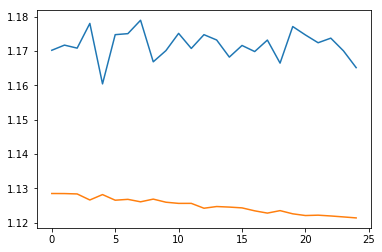

In [89]:
plt.plot(hist.history['val_mean_absolute_error'])
plt.plot(hist.history['mean_absolute_error'])
plt.show()

In [104]:
pred_nn = nn.predict(X_test)

In [105]:
pred_nn.max(axis=0)

array([ 1.27258527,  2.24805117], dtype=float32)

In [77]:
nn.save('football_model_odds.h5')

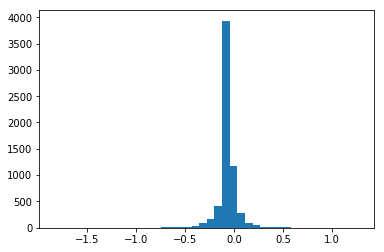

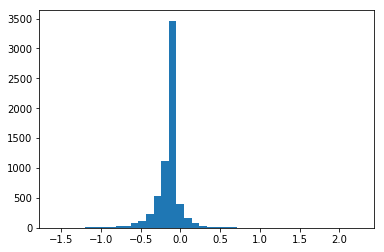

In [101]:
plt.hist(pred_nn[:,0],bins=40)
plt.show()
plt.hist(pred_nn[:,1],bins=40)
plt.show()

In [102]:
np.max(pred_nn)

2.2480512

1.0


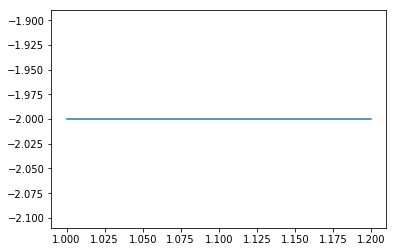

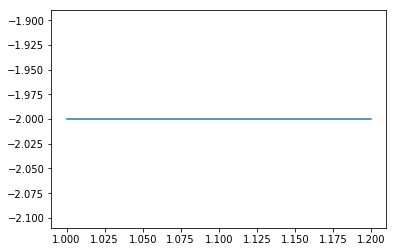

1.0

In [110]:
winnings =  []
bets_made = []
threshold = np.linspace(1,1.2,40)
for t in threshold:
    cash = 0
    b = 0
    for i in range(len(pred_nn)):
        if pred_nn[i][0] > t:
            cash -= 1
            cash += y_test['HomeValue'].iloc[i]
            b +=1
    winnings.append(cash)
    bets_made.append(b)
    #     elif pred_nn[i][1] > 0:
    #         cash += y_test['AwayValue'].iloc[i]

print(np.mean(bets_made))
plt.plot(threshold,winnings)
plt.show()
plt.plot(threshold, np.array(winnings)/np.array(bets_made))
plt.show()
threshold[np.argmax(winnings)]

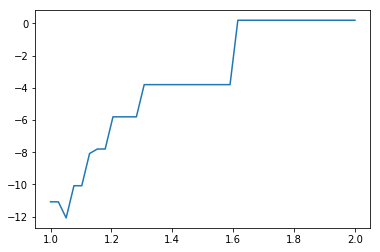

1.6153846153846154

In [111]:
winnings =  []

threshold = np.linspace(1,2,40)
for t in threshold:
    cash = 0

    for i in range(len(pred_nn)):
        if pred_nn[i][0] > 1.5:
            cash -=1
            cash += y_test['HomeValue'].iloc[i]
        elif pred_nn[i][1] > t:
            cash -=1
            cash += y_test['AwayValue'].iloc[i]
            
    winnings.append(cash)
    
plt.plot(threshold,winnings)
plt.show()
threshold[np.argmax(winnings)]

41 home bets, 4 away bets
Expected on bet:  -0.165777773327


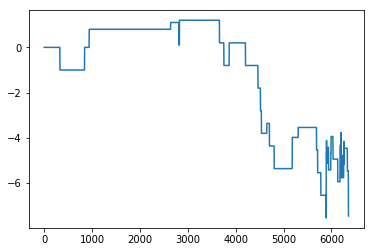

In [41]:
cash = 0
winnings = []
hb = 0
ab = 0

for i in range(len(pred_nn)):
    if pred_nn[i][0] > 1.1:
        cash -= 1
        cash += y['HomeValue'].iloc[i]
        hb += 1
    elif pred_nn[i][1] > 1.05:
        cash -= 1
        cash += y['AwayValue'].iloc[i]
        ab += 1
        
    winnings.append(cash)

bets_made = hb+ab
print("{} home bets, {} away bets".format(hb,ab))
print("Expected on bet: ", winnings[-1]/bets_made)
plt.plot(winnings)
plt.show()

In [42]:
pred_nn = nn.predict(X_train)

In [43]:
pred_nn.max(axis=0)

array([ 1.36740601,  1.31093538], dtype=float32)